## Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Fit prior

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [7]:
print(prior_a, prior_b)

0.9492941782464519 16.534909180069906


In [8]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

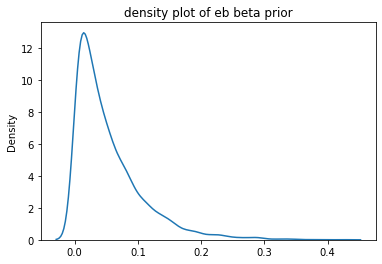

In [9]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

## Step 2: Train/test split

In [10]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [11]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0,0.145996
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,0,0.145996
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.145996
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.145996
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,0,0.145996


Text(0.5, 1.0, 'histogram of like ratios')

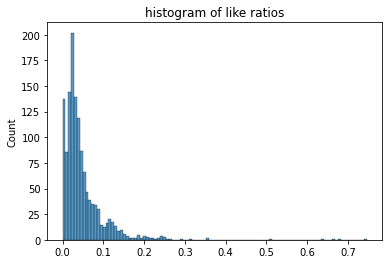

In [12]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [14]:
num_samples = 100
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]
video_df[sampled_videos].sort_values()

video_id
9136    0.000000
7566    0.000000
883     0.000000
8696    0.000000
4664    0.000709
          ...   
1205    0.122165
858     0.136782
2311    0.138396
2687    0.155209
7076    0.246634
Name: liked, Length: 100, dtype: float64

In [15]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[-1, -2, num_samples//5, 2*num_samples//5, 3*num_samples//5, 4*num_samples//5]].keys())
videos_of_interest

[7076, 2687, 2678, 627, 1377, 7257]

In [16]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [184]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T
# eb_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2) + np.array([0,1])

In [18]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

### Get environment from running the market for a very long time

In [44]:
def get_environment(df, 
                    videos, 
                    priors, 
                    sampling_action, 
                    timesteps,
                    num_sims):

    posteriors = []
    actions = range(len(videos))
        
    for n in range(num_sims):
        print(f'simulation {n+1}/{num_sims}')
        successes, failures = copy.deepcopy(priors[:,0]), copy.deepcopy(priors[:,1])
        for t in range(timesteps):

            a = sampling_action(actions, successes, failures)
            like = sample_chosen_df(videos, df, a)

            # update prior
            successes[a] += like
            failures[a] += 1 - like
            
        posteriors.append([successes, failures])
            
    return np.array(posteriors) 

## Step 4: Simulate!

In [207]:
timesteps = 30000
num_sims = 10

In [208]:
uninf_posterior = get_environment(kuairec_chosen, sampled_videos, uninformed_priors, ts_action, timesteps, num_sims)

simulation 1/10
simulation 2/10
simulation 3/10
simulation 4/10
simulation 5/10
simulation 6/10
simulation 7/10
simulation 8/10
simulation 9/10
simulation 10/10


In [209]:
eb_posterior = get_environment(kuairec_chosen, sampled_videos, eb_priors, ts_action, timesteps, num_sims)

simulation 1/10
simulation 2/10
simulation 3/10
simulation 4/10
simulation 5/10
simulation 6/10
simulation 7/10
simulation 8/10
simulation 9/10
simulation 10/10


In [210]:
# save the posteriors if need be
with open('uninf_posterior.npy', 'wb') as f:
    np.save(f, uninf_posterior)
    f.close()
with open('eb_posterior.npy', 'wb') as f:
    np.save(f, eb_posterior)
    f.close()

## Step 5: Bring in a new product to the market and see what happens

In [211]:
# 'average' video
ids_of_interest = [1377, 4040]
aug_df = dict()
for k in ids_of_interest:
    aug_df[k] = kuairec_test[(kuairec_test['video_id'].isin(sampled_videos))|(kuairec_test['video_id']==k)]

In [212]:
second_timesteps = 100

In [213]:
def simulate_populated_env(df,
                           videos,
                           prior,
                           sampling_action,
                           posteriors,
                           new_product,
                           timesteps):
    trajectories = []
    new_videos = videos[:]
    new_videos.append(new_product)
    for sim in range(posteriors.shape[0]):
        print(f'simulation {sim+1}/{posteriors.shape[0]}')
        
        curr_mkt = np.concatenate([posteriors[sim].T, np.expand_dims(prior,axis=0)])
        hist = np.expand_dims(copy.deepcopy(prior),axis=0)
        successes, failures = curr_mkt[:,0], curr_mkt[:,1]
        actions = range(curr_mkt.shape[0])
        for t in range(timesteps):
            a = sampling_action(actions, successes, failures)
            like = sample_chosen_df(new_videos, df, a)

            # update prior
            successes[a] += like
            failures[a] += 1 - like
            hist = np.concatenate([copy.deepcopy(hist), np.expand_dims(np.array([successes[-1], failures[-1]]),axis=0)])
                
        trajectories.append(hist)
        
    return np.array(trajectories)

In [214]:
trajects = dict()

for k in ids_of_interest:
    print(k, 'uninf')
    trajects[(k,'uninf')] = simulate_populated_env(aug_df[k], 
                                                   sampled_videos, 
                                                   copy.deepcopy(uninformed_priors[0]),
                                                   ts_action, 
                                                   uninf_posterior,
                                                   k,
                                                   second_timesteps)
    print(k, 'eb')
    trajects[(k,'eb')] = simulate_populated_env(aug_df[k], 
                                                sampled_videos, 
                                                copy.deepcopy(eb_priors[0]),
                                                ts_action, 
                                                eb_posterior,
                                                k,
                                                second_timesteps)

1377 uninf
simulation 1/10
simulation 2/10
simulation 3/10
simulation 4/10
simulation 5/10
simulation 6/10
simulation 7/10
simulation 8/10
simulation 9/10
simulation 10/10
1377 eb
simulation 1/10
simulation 2/10
simulation 3/10
simulation 4/10
simulation 5/10
simulation 6/10
simulation 7/10
simulation 8/10
simulation 9/10
simulation 10/10
4040 uninf
simulation 1/10
simulation 2/10
simulation 3/10
simulation 4/10
simulation 5/10
simulation 6/10
simulation 7/10
simulation 8/10
simulation 9/10
simulation 10/10
4040 eb
simulation 1/10
simulation 2/10
simulation 3/10
simulation 4/10
simulation 5/10
simulation 6/10
simulation 7/10
simulation 8/10
simulation 9/10
simulation 10/10


## Step 6: Plot the data from our new products and see what happens

In [215]:
traject_data = copy.deepcopy(trajects)
for k in traject_data:
    traject_data[k] = traject_data[k][:,:,0]/(traject_data[k][:,:,0]+traject_data[k][:,:,1])
    df = pd.DataFrame(traject_data[k]).melt()
    df = df.rename(columns={'variable': 'timestep'})
    traject_data[k] = df
        

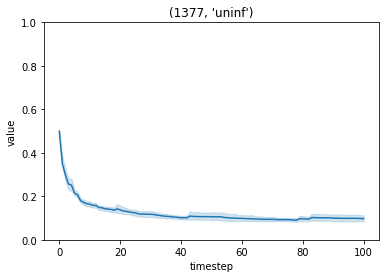

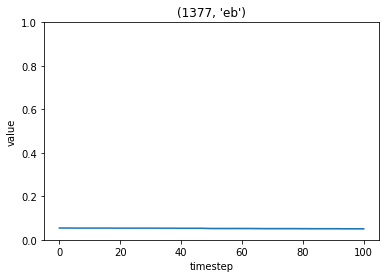

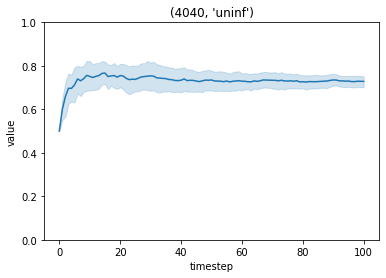

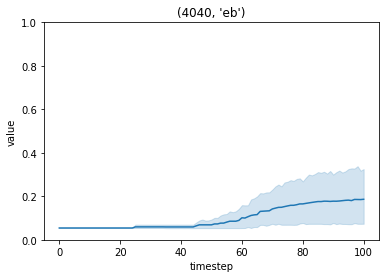

In [218]:
for k in traject_data:
    plt.figure()
    plt.ylim(0, 1)
    sns.lineplot(traject_data[k],x='timestep',y='value').set_title(k)